In [4]:
import pandas as pd
from scipy.io import mmread
import scanpy as sc
import numpy as np
import anndata as ad
import logging
import gprofiler
import os
from scipy import sparse
from single_cell_new.functions.mofa_candidate import mofa_candidates
from single_cell_new.functions.partition_assignemnt import partition_assignment
from sklearn.metrics import precision_recall_curve, f1_score, auc
import feyn

from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
#import wikipedia
import collections
from single_cell_new.functions.tpm import counts2tpm
from single_cell_new.functions.model_eval import *
import os


sc.settings.verbosity = 1

In [9]:
def load_and_split(dataset_number, min_cells):
    load_path = '../UC%s_final.h5ad' %( dataset_number)
    matrix_ = sc.read_h5ad(load_path)#, backed=None, *, as_sparse=(), as_sparse_fmt=<class 'scipy.sparse._csr.csr_matrix'>, chunk_size=6000)
    info_ = matrix_.obs[['sample', 'disease_state']].reset_index()[['sample', 'disease_state']]
    matrix_.layers["log_transformed"] = matrix_.X
    annotation_scBert = '../scBERT_Folder/Predictions/UC%s_Predictions.txt' % (dataset_number)
    annotation_scBert_df = pd.read_table(annotation_scBert, header=None)
    annotation_scBert_df.columns = ['Cell_type']
    matrix_.obs["Cell_type"] = list(annotation_scBert_df['Cell_type'])
    #print(matrix_.obs.Cell_type.value_counts())
    df1  = pd.DataFrame(matrix_.obs.Cell_type.value_counts())
    df1  = df1.reset_index()
    df1.columns =['Cell_type','Cell_Counts']
    df1.Cell_Counts = df1.Cell_Counts.astype(int)
    min_cells = 10 #int(len(matrix_.obs)/100)
    print('Keeping cell types with at least {} cells for UC{}'.format(min_cells, dataset_number))

    cell_toKeep = list(df1.query(f'Cell_Counts >= {min_cells}').Cell_type)
    
    matrix_ = matrix_[matrix_.obs.Cell_type.isin(cell_toKeep)]
    cl_numbers = partition_assignment(np.array(matrix_.obs.PatientID), np.array(matrix_.obs.UC_state), 1, 2)
    matrix_.obs['CV_SPLIT'] = cl_numbers
    train = matrix_[matrix_.obs.CV_SPLIT == 0.0]
    sc.pp.highly_variable_genes(train, flavor='seurat', n_top_genes=4000)
    print('\n','Number of highly variable genes: {:d}'.format(np.sum(train.var['highly_variable'])))
    print('\n','Number of kept cell types: {:d}'.format(len(cell_toKeep)))
    matrix_var_filtered = matrix_[:,train.var.highly_variable].copy()
    var_genes = list(matrix_var_filtered.var.index)
    
    return matrix_, var_genes, cell_toKeep

In [10]:
%%capture
from functools import reduce
all_genes = list()
all_cells = list()
df_dict = dict()
cells_to_remove = list()
for i in [1,2,3,5]:
    cells_to_remove_tmp = list()
    adata, var_genes_, cell_toKeep_ = load_and_split(i, 500)
    all_genes.append(var_genes_)
    all_cells.append(cell_toKeep_)
    df_dict_tmp = dict()
    for cell_type in cell_toKeep_:
        n_classes = adata[adata.obs['Cell_type']==cell_type].obs['UC_state'].value_counts()
        if len(n_classes) == 2:
            df_dict_tmp[cell_type] = adata[adata.obs['Cell_type']==cell_type].to_df()
            df_dict_tmp[cell_type]['UC_state'] = adata[adata.obs['Cell_type']==cell_type].obs['UC_state']
            df_dict_tmp[cell_type]['CV_SPLIT'] = adata[adata.obs['Cell_type']==cell_type].obs['CV_SPLIT']
        else:
            cells_to_remove_tmp.append(cell_type)
    cells_to_remove.append(cells_to_remove_tmp)
        
    df_dict["UC{}".format(i)] = df_dict_tmp
    


In [11]:
cells_to_remove

[['Mast cell', 'Immature pericyte'],
 ['venous capillary', 'LEC4 (STAB2+)'],
 ['CD8 Tmem', 'Monocytes'],
 ['TRDV2/TRGV9 gdT', 'Mature venous EC']]

In [12]:
final_list_feats= list(set.intersection(*map(set,all_genes)))
final_list_feats = final_list_feats +['UC_state']
final_list_cells = []
for i, cell_list_1 in enumerate(all_cells):
    for j, cell_list_2 in enumerate(all_cells[i+1:]):
        final_list_cells+=list(set(cell_list_1) & set(cell_list_2))
final_list_cells = list(set(final_list_cells))

In [13]:
len(final_list_cells)

44

## Train using the QLattice on the full dataset

In [15]:
performance_dict_train = dict()
for i, cells_list in enumerate(all_cells):

    performance_dict_train["UC_{}".format(current_dataset)] = dict()

    for cell_type in cells_list:
        if cell_type not in cells_to_remove[i]:    
            target = "UC_state"
            save_string = "../models/UC{}/UC{}_{}".format(current_dataset, current_dataset, cell_type)
            os.mkdir(save_string)
            stypes = {}

            random_seed = 42
            df_1 = df_dict['UC{}'.format(current_dataset)][cell_type]

            train = df_1
            train = train.drop(columns=['CV_SPLIT'])

            class_low = pd.DataFrame(train[target].value_counts()).index[-1]
            sw = np.where(train[target] == int(class_low), np.sum(train[target] == 0)/sum(train[target]), 1)    

            ql = feyn.QLattice(random_seed)
            models = ql.auto_run(
                data=train[final_list_feats],
                output_name=target,
                kind="classification",
                criterion='bic',
                stypes=stypes,
                sample_weights=sw,
                max_complexity=3,
                n_epochs=30,
            )
            performance_dict_train["UC_{}".format(current_dataset)][cell_type] = models[0].roc_auc_score(train)
            for n, model in enumerate(models):          
                model.save(file=save_string+"/UC{}_{}_model_{}".format(current_dataset, cell_type, n))

PermissionError: [Errno 13] Permission denied: '/home/jupyter-marco.salvatore/jupyter_lab_files/single_cell_new/models/UC1/UC1_Colonocyte'

In [8]:
performance_df_train_ = pd.DataFrame(performance_dict_train)

In [48]:
performance_df_train_

,UC_1,UC_2,UC_3,UC_5
Colonocyte,0.802466,NaN,0.865330,NaN
TA,0.840154,NaN,0.858747,NaN
BEST2+ Goblet cell,0.859453,NaN,0.846621,NaN
Stromal 2 (NPY+),0.775009,0.949892,NaN,NaN
Stromal 1 (ADAMDEC1+),0.921098,0.972308,NaN,NaN
...,...,...,...,...
Pro-B,NaN,NaN,NaN,0.75
Lymphoid DC,NaN,NaN,NaN,1.00
FCRL4+ Memory B,NaN,NaN,NaN,0.75
Th17,NaN,NaN,NaN,1.00


## Create intersection list to compute permutation to predict on each cell type on each dataset with each model

In [20]:
def intersection_cells(data1, data2):
    string1 = "../models/UC{}/".format(data1)
    string2 = "../models/UC{}/".format(data2)

    list_1 = list()
    list_2 = list()
    for i1 in os.listdir(string1):
        list_1.append(i1.split('_')[1])

    for i2 in os.listdir(string2):
        list_2.append(i2.split('_')[1])

    z = set(list_2).intersection(set(list_1))

    return list(z)

## Do the permutation to have all the info 

In [21]:
dict_cell_models = dict()
import itertools
foo = [[1, 2, 3, 5], [2], [3], [5]]
for p in itertools.permutations(foo, 2):
    data = list(zip(*p))[0]
    dict_cell_models['UC'+str(data[0])+'_UC'+str(data[1])] = intersection_cells(data[0], data[1])

In [22]:
#dict_cell_models

## (Re)Fit/Predict on the other dataset where the same cell type is present

In [102]:
for d1, d2 in dict_cell_models.items():
    target = "UC_state"    
    current_dataset = d1.split('_')[0]
    test_dataset = d1.split('_')[1]

    for cells_ in d2:
        target = "UC_state"
        stypes = {}
        #print(cells_)
        df_1 = df_dict['{}'.format(test_dataset)][cells_]
        save_string = "../models/{}/{}_{}".format(current_dataset, current_dataset, cells_)
        save_string_new = "../models_refit/{}/{}_{}".format(current_dataset, current_dataset+'_'+test_dataset, cells_)
        os.mkdir(save_string_new)
            
        train = df_1
        train = train.drop(columns=['CV_SPLIT'])
        class_low = pd.DataFrame(train[target].value_counts()).index[-1]
        sw = np.where(train[target] == int(class_low), np.sum(train[target] == 0)/sum(train[target]), 1)
        
        for n in range(10): 
            #print(n, model)
            model1 = Model.load(file=save_string+"/{}_{}_model_{}".format(current_dataset, cells_, n))
            #print(model1.to_query_string())
            list_torefit = model1.features + ['UC_state']
            random_seed = 42
            
            ql = feyn.QLattice(random_seed)

            models = ql.auto_run(
                data=train[list_torefit],
                output_name=target,
                kind="classification",
                criterion='bic',
                stypes=stypes,
                sample_weights=sw,
                max_complexity=3,
                n_epochs=5,
                query_string=model1.to_query_string()
            )
    
            models[0].save(file=save_string_new+"/{}_{}_model_{}".format(current_dataset, cells_, n))


In [106]:
%%capture
dataset = list()
cells = list()
score = list()
for d1, d2 in dict_cell_models.items():
    target = "UC_state"    
    current_dataset = d1.split('_')[0]
    test_dataset = d1.split('_')[1]

    for cells_ in d2:

        #print(cells_)
        df_1 = df_dict['{}'.format(test_dataset)][cells_]
        save_string = "../models_refit/{}/{}_{}".format(current_dataset, current_dataset+'_'+test_dataset, cells_)
        train = df_1
        train = train.drop(columns=['CV_SPLIT'])

        for n in range(10): 
            #print(n, model)
            model1 = Model.load(file=save_string+"/{}_{}_model_{}".format(current_dataset, 'Mature venous EC', n))#cells_, n))
            dataset.append(d1)
            cells.append(cells_) 
            score.append(model1.roc_auc_score(train))
            #model_precision, model_recall, _ = precision_recall_curve(train[model1.output], model1.predict(train))
            #score_pr = auc(model_recall, model_precision).round(3)
            #score.append(score_pr)
               

## Predict on the trained dataset 

In [ ]:
%%capture

dataset_t = list()
cells_t = list()
score_t = list()

for i, cells_list in enumerate(all_cells):
    if i == 3:
        current_dataset = 5
    else:
        current_dataset = i + 1
    for cell_type in cells_list:
        if cell_type not in cells_to_remove[i]:    
            target = "UC_state"
            save_string = "../models/UC{}/UC{}_{}".format(current_dataset, current_dataset, cell_type)
           
            df_1 = df_dict['UC{}'.format(current_dataset)][cell_type]

            train = df_1
            train = train.drop(columns=['CV_SPLIT'])
            
            for n in range(10): 
                #print(n, model)
                #model.save(file=save_string+"/UC{}_{}_model_{}".format(current_dataset, cell_type, n))
                model1 = Model.load(file=save_string+"/UC{}_{}_model_{}".format(current_dataset, cell_type, n))
                dataset_t.append('UC{}'.format(current_dataset))
                cells_t.append(cell_type) 
                score_t.append(model1.roc_auc_score(train))
                #model_precision, model_recall, _ = precision_recall_curve(train[model1.output], model1.predict(train))
                #score_pr = auc(model_recall, model_precision).round(3)
                #score_t.append(score_pr)         


# Make Final Dataframes

In [108]:
final_dataframe = pd.DataFrame(list(zip(dataset, cells, score)), columns=['dataset', 'celltype', 'pr_auc'])

In [109]:
final_dataframe_n = pd.DataFrame(list(zip(dataset_t, cells_t, score_t)), columns=['dataset', 'celltype', 'pr_auc'])

## Define Model selection function

In [112]:
def select_models(cell_, data_1, data_2, data_3, data_4):

    tmp_df = pd.concat([final_dataframe_n.query('celltype == @cell_ & dataset == @data_1').reset_index(),
                        final_dataframe_n.query('celltype == @cell_ & dataset == @data_2').reset_index(),
                        final_dataframe.query('dataset == @data_3 & celltype== @cell_').reset_index(),
                        final_dataframe.query('dataset == @data_4 & celltype== @cell_').reset_index()], axis=1
             )
    tmp_df.columns = ['index1','dataset1','celltype1','pr_auc1',
                      'index2','dataset2','celltype2','pr_auc2',
                      'index3','dataset3','celltype3','pr_auc3',
                      'index4','dataset4','celltype4','pr_auc4']

    tmp_df = tmp_df[['celltype1','dataset1', 'pr_auc1',
                   'dataset2','pr_auc2',  
                   'dataset3','pr_auc3',
                   'dataset4','pr_auc4']]
    
    tmp_df['delta1'] = tmp_df.pr_auc1 - tmp_df.pr_auc3 
    tmp_df['delta2'] = tmp_df.pr_auc2 - tmp_df.pr_auc4 

    return tmp_df

In [ ]:
final_dataframe.to_csv('final_dataframe_refit.csv', index=False)

In [113]:
dict_res = dict()
for cells_i in dict_cell_models['UC1_UC3']:
    #print(cells_i)
    dict_res[cells_i] = select_models(cells_i, 'UC1', 'UC3', 'UC1_UC3', 'UC3_UC1')#.query('delta2 <= 0.10 | delta1 <= 0.10')

# Calculate statistics and make tables

In [559]:
base_string = '../single_cell_new'

In [560]:
model_string_refit = base_string + "/models_refit_new1"

In [561]:
model_string_original = base_string + "/models_new"

In [562]:
master_dict_refit = dict()
master_dict_original = dict()

In [563]:
import os
from feyn import Model
for directory in os.listdir(model_string_original):
    cur_dir = model_string_original + "/{}".format(str(directory))
    for cell_model_ in os.listdir(cur_dir):
        cell_model_path = cur_dir + "/{}".format(cell_model_)
        
        trained_data = cell_model_[0:3]
        cell_type = cell_model_[4:]
        
        if trained_data not in list(master_dict_original.keys()):
            master_dict_original[trained_data] = dict()
        
        master_dict_original[trained_data][cell_type] = [Model.load(cell_model_path+"/{}".format(m)) for m in os.listdir(cell_model_path)]

In [564]:
import os
from feyn import Model
for directory in os.listdir(model_string_refit):
    cur_dir = model_string_refit + "/{}".format(str(directory))
    for cell_model_ in os.listdir(cur_dir):
        cell_model_path = cur_dir + "/{}".format(cell_model_)
        
        trained_data = cell_model_[0:3]
        refit_data = cell_model_[4:7]
        cell_type = cell_model_[8:]
        
        if trained_data not in list(master_dict_refit.keys()):
            master_dict_refit[trained_data] = dict()
        
        if refit_data not in list(master_dict_refit[trained_data].keys()):
            master_dict_refit[trained_data][refit_data] = dict()
        
        master_dict_refit[trained_data][refit_data][cell_type] = [Model.load(cell_model_path+"/{}".format(m)) for m in os.listdir(cell_model_path)]

In [565]:
kept_cell_types = []

In [566]:
import itertools
for trained_key in list(master_dict_refit.keys()):
    for refit_key in list(master_dict_refit[trained_key].keys()):
        cell_list = list(master_dict_refit[trained_key][refit_key].keys())
        kept_cell_types.append(cell_list)

kept_cell_types_cat = list(itertools.chain.from_iterable(kept_cell_types))

kept_cell_types_final = list(set(kept_cell_types_cat))

In [567]:
matrix_dict = dict()

In [568]:
import numpy
matrix_cellbool = np.zeros((len(kept_cell_types_final), 4))

In [569]:
dict_cellbool = dict()
for trained_key in list(master_dict_refit.keys()):
    dict_cellbool[trained_key] = dict()
    for cell_type in kept_cell_types_final:
        dict_cellbool[trained_key][cell_type] = False

In [570]:
for trained_key in list(master_dict_refit.keys()):
    for refit_key in list(master_dict_refit[trained_key].keys()):
        for cell_type in kept_cell_types_final:
            if cell_type in list(master_dict_refit[trained_key][refit_key].keys()):
                dict_cellbool[trained_key][cell_type] = True

In [571]:
dict_cellbool["UC1"]

{'Activated CD8 T': False,
 'Stromal 4 (MMP1+)': True,
 'Stem cells': True,
 'Memory B': False,
 'Naive B': False,
 'EC cells (TAC1+)': True,
 'Stromal 1 (CCL11+)': True,
 'Mast cell': False,
 'gdT': False,
 'Fetal venous EC': True,
 'Stromal 2 (NPY+)': True,
 'Contractile pericyte (PLN+)': True,
 'Tfh': False,
 'Fetal arterial EC': True,
 'TRGV4 gdT': False,
 'cDC2': True,
 'mLTo': True,
 'BEST2+ Goblet cell': True,
 'arterial capillary': True,
 'BEST4+ epithelial': True,
 'Pericyte': True,
 'Mature arterial EC': True,
 'myofibroblast': True,
 'Stromal 1 (ADAMDEC1+)': True,
 'TA': True,
 'T reticular': True,
 'NK cell': False,
 'Transitional Stromal 3 (C3+)': True,
 'Stromal 3 (C7+)': True,
 'Activated CD4 T': False,
 'Treg': False,
 'Colonocyte': True,
 'Mature venous EC': True,
 'Activated T': True,
 'SELL+ CD4 T': False,
 'myofibroblast (RSPO2+)': True,
 'IgA plasma cell': True,
 'Cycling B cell': True,
 'Goblet cell': True,
 'Adult Glia': True}

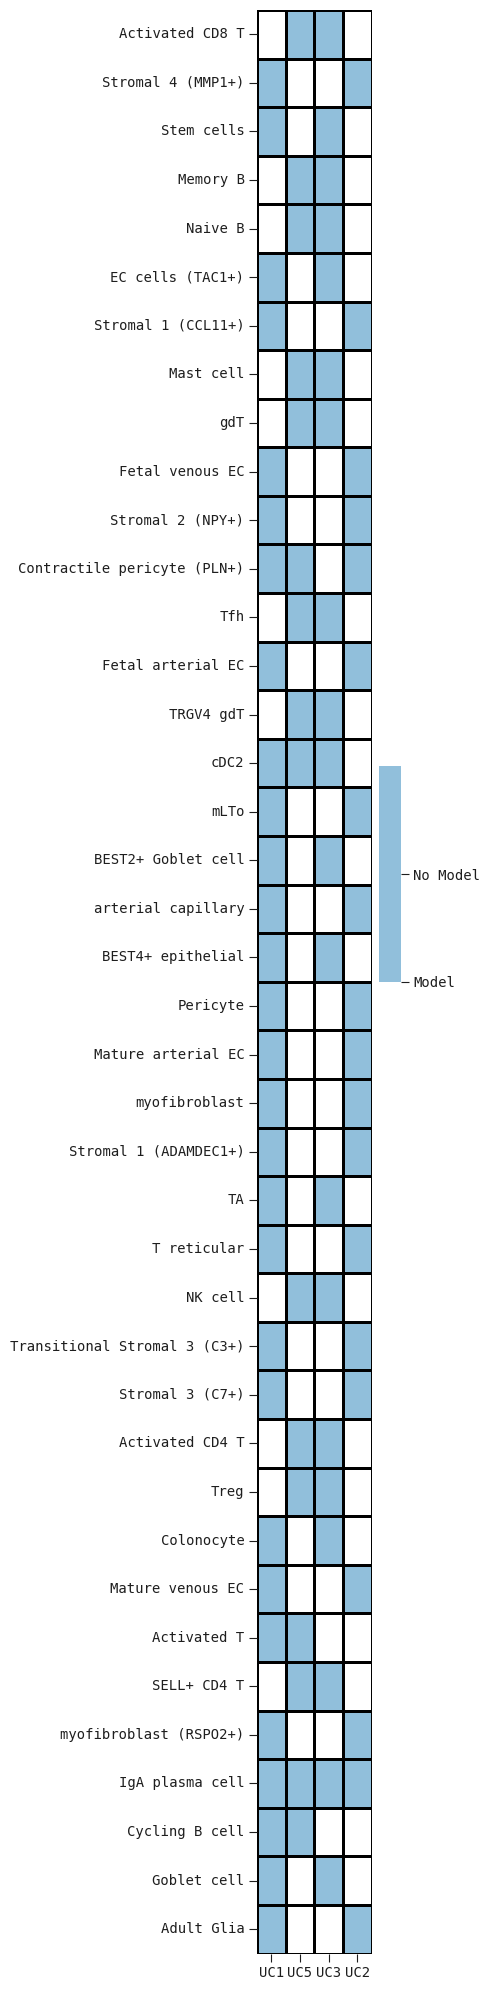

In [572]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
df_cellbool = pd.DataFrame(dict_cellbool)
#df_cellbool = df_cellbool.T
colors = ['white', '#91BFDB']
cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))
plt.figure(figsize = (5,20))
ax = sns.heatmap(df_cellbool, cmap=cmap, linecolor="black", linewidths=1, xticklabels=1, yticklabels=1)

# Set the colorbar labels
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.75,0.5])
colorbar.set_ticklabels(['No Model', 'Model'])

plt.yticks(rotation=0) 

fig = ax.get_figure()
plt.tight_layout()
fig.savefig("matrix_celltypebools.pdf")

In [573]:
df_refit = pd.read_csv("../single_cell_new/final_dataframe_refit_new1.csv")
df_train = pd.read_csv("../single_cell_new/final_dataframe_train_new1.csv")

In [574]:
cell_counts_UC1 = pd.read_csv("../single_cell_new/Cell_Counts/cell_counts_UC1.csv")
cell_counts_UC2 = pd.read_csv("../single_cell_new/Cell_Counts/cell_counts_UC2.csv")
cell_counts_UC3 = pd.read_csv("../single_cell_new/Cell_Counts/cell_counts_UC3.csv")
cell_counts_UC4 = pd.read_csv("../single_cell_new/Cell_Counts/cell_counts_UC4.csv")

In [640]:
fraction_counts_UC1 = pd.read_csv("../single_cell_new/Cell_Fractions/fraction_UC1_new.csv")
fraction_counts_UC2 = pd.read_csv("../single_cell_new/Cell_Fractions/fraction_UC2_new.csv")
fraction_counts_UC3 = pd.read_csv("../single_cell_new/Cell_Fractions/fraction_UC3_new.csv")
fraction_counts_UC4 = pd.read_csv("../single_cell_new/Cell_Fractions/fraction_UC4_new.csv")

fraction_counts_UC1 = fraction_counts_UC1.rename(columns={"0": "Control", "1": "UC"})
fraction_counts_UC2 = fraction_counts_UC2.rename(columns={"0": "Control", "1": "UC"})
fraction_counts_UC3 = fraction_counts_UC3.rename(columns={"0": "Control", "1": "UC"})
fraction_counts_UC4 = fraction_counts_UC5.rename(columns={"0": "Control", "1": "UC"})

In [641]:
fraction_counts_UC3

,Control,UC,Cell_type
0,0.580685,0.419315,Colonocyte
1,0.651163,0.348837,gdT
2,0.833333,0.166667,SELL+ CD4 T
3,0.584262,0.415738,BEST2+ Goblet cell
4,0.642680,0.357320,TA
5,0.571739,0.428261,Activated CD8 T
6,0.518519,0.481481,TRGV4 gdT
7,0.615385,0.384615,Goblet cell
8,0.645485,0.354515,BEST4+ epithelial
9,0.692308,0.307692,Activated CD4 T


In [642]:
ccount_dict = {"UC1": cell_counts_UC1, "UC2": cell_counts_UC2, "UC3": cell_counts_UC3, "UC4": cell_counts_UC4}

In [643]:
fraction_dict = {"UC1": fraction_counts_UC1, "UC2": fraction_counts_UC2, "UC3": fraction_counts_UC3, "UC4": fraction_counts_UC4}

In [660]:
%%capture
from collections import Counter

master_performance_df = pd.DataFrame(columns=["Train Data ID", "Refit Data ID", "Cell Type", "Train Data PR AUC", 
                                              "Refit Data PR AUC", "PR AUC Delta", "Dominant Features", 
                                              "Avg. PR AUC", "PR AUC", "Score", "Raw Count - Train", "Raw Count - Refit", "Count", "UC Fraction"])


for trained_key in list(master_dict_refit.keys()):
    for refit_key in list(master_dict_refit[trained_key].keys()):
        for cell_type in list(master_dict_refit[trained_key][refit_key].keys()):
            orig_performance = np.round(df_train[df_train["dataset"] == trained_key][df_train["celltype"] == cell_type]["pr_auc"].mean(),2)
            
            refit_str = "{}_{}".format(trained_key, refit_key)
            
            refit_performance = np.round(df_refit[df_refit["dataset"] == refit_str][df_refit["celltype"] == cell_type]["pr_auc"].mean(),2)
            
            pr_auc_delta = np.abs(np.round(refit_performance - orig_performance,2))
            
            score = np.round(0.5*orig_performance + 0.5*refit_performance - pr_auc_delta,2)
            avg_auc = np.round(0.5*orig_performance + 0.5*refit_performance, 2)
            
            models = master_dict_refit[trained_key][refit_key][cell_type]

            features = list(itertools.chain.from_iterable([m.features for m in models]))
            
            counts = Counter(features)
            counts_sorted = list({k: v for k, v in sorted(dict(counts).items(), key=lambda item: item[1])}.keys())
            
            f1 = counts_sorted[-1]
            f2 = counts_sorted[-2]
            
            dominant_features = str(f1) + "," + str(f2)
            
            refit_cell_count = ccount_dict[refit_key][ccount_dict[refit_key]["Cell_type"] == cell_type]["Cell_Counts"].sum()
            orig_cell_count = ccount_dict[trained_key][ccount_dict[trained_key]["Cell_type"] == cell_type]["Cell_Counts"].sum()
            
            refit_control = np.round(fraction_dict[refit_key][fraction_dict[refit_key]["Cell_type"] == cell_type]["Control"].sum(), 2)
            refit_uc = np.round(fraction_dict[refit_key][fraction_dict[refit_key]["Cell_type"] == cell_type]["UC"].sum(),2)
            
            orig_control = np.round(fraction_dict[trained_key][fraction_dict[trained_key]["Cell_type"] == cell_type]["Control"].sum(), 2)
            orig_uc = np.round(fraction_dict[trained_key][fraction_dict[trained_key]["Cell_type"] == cell_type]["UC"].sum(),2)
            
            if (orig_control + orig_uc) > 1.02:
                orig_control = orig_control/2
                orig_uc = orig_uc/2
            
            if (refit_control + refit_uc) > 1.02:
                refit_control = refit_control/2
                refit_uc = refit_uc/2 
            
            refit_fraction_str = str(refit_cell_count) + " - " + str(int(refit_uc*100)) + "%"
            orig_fraction_str = str(orig_cell_count) + " - " + str(int(orig_uc*100)) + "%"
            auc_str = str(orig_performance) + "/" + str(refit_performance)
            
            count_col = str(orig_cell_count) + "/" + str(refit_cell_count)
            frac_col = str(int(orig_uc*100)) + "%" + "/" + str(int(refit_uc*100)) + "%"
            
            data_list = [trained_key, refit_key, cell_type, orig_performance, refit_performance, pr_auc_delta, dominant_features, avg_auc, auc_str,score, orig_cell_count, refit_cell_count, count_col, frac_col]
            
            data_df = pd.DataFrame([data_list], columns=["Train Data ID", "Refit Data ID", "Cell Type", 
                                                         "Train Data PR AUC", "Refit Data PR AUC", "PR AUC Delta", 
                                                         "Dominant Features", "Avg. PR AUC", 
                                                         "PR AUC",
                                                         "Score", "Raw Count - Train", "Raw Count - Refit",
                                                        "Count", "UC Fraction"])
            # if refit_cell_count > 100:
                # if orig_cell_count > 100:
                    # if score > 0.8:
                        # if refit_uc > 0.20:
                            # master_performance_df= master_performance_df.append(data_df)
            #if trained_key == "UC2":
                #if refit_cell_count > 50:
                    #if orig_cell_count > 50:
                        # if score > 0.5:
                            # if refit_uc > 0.1:
                                # master_performance_df= master_performance_df.append(data_df)
            master_performance_df = master_performance_df.append(data_df)

In [664]:
master_performance_df[master_performance_df["Train Data ID"] == "UC5"].sort_values(by="Score", ascending=False).head(20)[["Train Data ID", "Refit Data ID", "Cell Type", "Dominant Features", "PR AUC", "Score", "Count", "UC Fraction"]]

,Train Data ID,Refit Data ID,Cell Type,Dominant Features,PR AUC,Score,Count,UC Fraction
0,UC5,UC3,Treg,"RPL39,CD7",0.95/0.98,0.94,4304/121,15%/8%
0,UC5,UC3,Tfh,"DDIT4,PPP1R3E",0.89/0.98,0.85,53/25,19%/4%
0,UC5,UC3,Memory B,"RPS4Y1,ADAM28",0.87/0.97,0.82,3139/183,25%/5%
0,UC5,UC3,Naive B,"RPS4Y1,GEM",0.88/0.99,0.82,550/41,17%/2%
0,UC5,UC3,gdT,"RPL39,CD74",0.93/0.86,0.82,293/86,28%/35%
0,UC5,UC3,Activated CD8 T,"RPL39,KLF2",0.82/0.84,0.81,3212/460,41%/43%
0,UC5,UC1,cDC2,"LYZ,RPL39",0.81/0.83,0.80,192/81,43%/21%
0,UC5,UC3,SELL+ CD4 T,"CCL5,CD3D",0.85/0.96,0.80,2739/12,26%/17%
0,UC5,UC1,IgA plasma cell,"RPL39,CD79A",0.85/0.81,0.79,7597/1182,42%/25%
0,UC5,UC3,IgA plasma cell,"RPL39,CD79A",0.85/1.0,0.78,7597/46,42%/4%


In [614]:
%%capture
num_best = 10
sorted_df_final = pd.DataFrame(columns=list(master_performance_df.columns))

for i in [2, 3, 5]:
    df_ = master_performance_df.query("(`Train Data ID` == 'UC1') & (`Refit Data ID` == 'UC{}')".format(i)).sort_values(by="Score", ascending=False).head(num_best)
    
    sorted_df_final = sorted_df_final.append(df_)

for i in [1, 3, 5]:
    df_ = master_performance_df.query("(`Train Data ID` == 'UC2') & (`Refit Data ID` == 'UC{}')".format(i)).sort_values(by="Score", ascending=False).head(1)
    
    sorted_df_final = sorted_df_final.append(df_)


for i in [1, 2, 3]:
    df_ = master_performance_df.query("(`Train Data ID` == 'UC5') & (`Refit Data ID` == 'UC{}')".format(i)).sort_values(by="Score", ascending=False).head(num_best)
    
    sorted_df_final = sorted_df_final.append(df_)

for i in [2, 1, 5]:
    df_ = master_performance_df.query("(`Train Data ID` == 'UC3') & (`Refit Data ID` == 'UC{}')".format(i)).sort_values(by="Score", ascending=False).head(num_best)
    
    sorted_df_final = sorted_df_final.append(df_)

In [615]:
sorted_df_final.sort_values(by=["Train Data ID", "Score"], ascending=[True, False])[["Train Data ID", "Refit Data ID", "Cell Type", "Dominant Features", "PR AUC", "Score", "Count - Train", "Count - Refit"]]

,Train Data ID,Refit Data ID,Cell Type,Dominant Features,PR AUC,Score,Count - Train,Count - Refit
0,UC1,UC2,arterial capillary,"RPL39,PLAT",0.95/0.94,0.94,1814 - 28%,559 - 22%
0,UC1,UC3,Goblet cell,"LYZ,LGALS4",0.94/0.92,0.91,1714 - 26%,325 - 38%
0,UC1,UC3,TA,"B3GNT7,FABP1",0.95/0.89,0.86,14930 - 35%,2821 - 36%
0,UC1,UC3,BEST2+ Goblet cell,"LYZ,FABP1",0.96/0.88,0.84,11444 - 24%,1436 - 42%
0,UC2,UC1,myofibroblast,"RPS4Y1,APOC1",0.94/0.92,0.91,105 - 45%,1189 - 16%
0,UC3,UC1,BEST2+ Goblet cell,"LCN2,FABP1",0.92/0.94,0.91,1436 - 42%,11444 - 24%
0,UC3,UC1,TA,"FABP1,LCN2",0.93/0.91,0.90,2821 - 36%,14930 - 35%
0,UC3,UC1,Stem cells,"LCN2,DDIT4",0.92/0.88,0.86,102 - 19%,123 - 21%
0,UC5,UC3,Activated CD8 T,"RPL39,KLF2",0.82/0.84,0.81,3212 - 41%,460 - 43%


In [510]:
avg_score_dict = dict()

for cell_type_ in kept_cell_types_final:
    avg_cell_score = master_performance_df[master_performance_df["Cell Type"] == cell_type_]["Score"].mean()
    avg_cell_AUC = master_performance_df[master_performance_df["Cell Type"] == cell_type_]["Avg. PR-AUC"].mean()
    avg_delta = master_performance_df[master_performance_df["Cell Type"] == cell_type_]["PR AUC Delta"].mean()
    
    avg_score_dict[cell_type_] = dict()
    avg_score_dict[cell_type_]["Avg. Score"] = avg_cell_score
    avg_score_dict[cell_type_]["Avg. PR-AUC"] = avg_cell_AUC
    avg_score_dict[cell_type_]["Avg. Delta"] = avg_delta

KeyError: 'Avg. PR-AUC'

In [391]:
avg_score_df = pd.DataFrame.from_dict(avg_score_dict, orient='index')


avg_score_df.sort_values(by="Avg. PR-AUC", ascending=False).head(20)

KeyError: 'Avg. PR-AUC'